In [30]:
import os
import json
import datetime
from collections import defaultdict
import re, string, unicodedata
import nltk
import statistics
from bs4 import BeautifulSoup
from nltk import sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import itertools
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import words
from collections import Counter
from nltk import bigrams
import operator
import networkx as nx
import pandas as pd
import plotly.graph_objects as go
from operator import itemgetter
from textblob import TextBlob
from nltk import pos_tag
from wordcloud import WordCloud

def set_chat_root(root):
    return root
chat_root = set_chat_root('/Users/ooganam/Downloads/facebook-ooganam/messages/inbox')

user_name = 'Ooga Nam'
def set_user_name(username):
    user_name = username
    


#user's messages
msg_user = []
#all messages, organized by discrete conversations and "message groups" (consecutive msgs sent by same user)
friend_data = defaultdict(dict)
friend_convos = defaultdict(dict)

def notin(target, comparelist):
    
    for element in comparelist:
        
        if element in target:
            return False

    return True

#text cleaning methods
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            stop = ['https','ur', 'im','u', 'hi', 'yea', 'yeah', 'gon', 'got', 'ta', 'iall', 'na', 'yo', 'hey', 'oh', 'dude', 'tho', 'ok', 'okay', 'wan', 'k']
            if word not in stop:
                new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    #print(words)
    #words = decontracted(words)
    return words

"""
For a single conversation json file (2-person chat), return stats of interest.

:return: list of dictionaries (each representing one participant in the conversation) 
"""

def reverse(messageList):
    messageList = list(messageList)
    return [messageList[-1*i] for i in range(1, len(messageList))]

def convertWholeChatToConvos(allmessages, interval):
    '''For a given friend, returns a list of convos
    that are comprised of message groups, ie consecutive 
    message in close proximity sent by same person'''
    
    #group messages by sender and time proximity - to make message groups
    allConvos = []
    currConvo = []
    messageGroup = [] # All by same person, near same times
    
    
    for message in allmessages:
        if 'content' in message.keys():
            if not messageGroup: # If current messageGroup is blank, naively add.
                messageGroup.append(message)

            else:   
                cur_sender = message['sender_name']
                cur_time = message['timestamp_ms']

                # If same messager sends two messages in close proximity
                if cur_sender == messageGroup[-1]['sender_name'] and \
                cur_time - messageGroup[-1]['timestamp_ms'] < 60*1000*10:
                        messageGroup.append(message)

                else: 
                    #if new message group is created, add it to the current convo
                    currConvo.append(messageGroup)

                    #if a new conversation is created, add the current convo to the convo list

                    if cur_time - messageGroup[-1]['timestamp_ms'] > 60*1000*60*interval:
                        allConvos.append(currConvo)
                        currConvo = []

                    #create new message group
                    messageGroup = [message]
    
    return allConvos

def find_lowest_slope(data):
    #experiment with time cutoff for beginning of new conversation                                         
    y= {i:len(convertWholeChatToConvos(data, i)) for i in range(10,50)}
    slopes = Counter()
    for hour in y:
        if hour < len(y) - 2:
            slopes[hour] = y[hour+2] - y[hour] 
    
    #find the hour that corresponds to the smallest change in conversation length
    minHour = 0
    minSlope = 999999
    for hour in slopes:
        if slopes[hour] < minSlope:
            minSlope = slopes[hour]
            minHour = hour
    
    return minHour
                                                
def getMessageGroupSentiment(content, length):
    totalSentiment = 0
    for message in content:
        totalSentiment += TextBlob(message['content']).polarity
    return totalSentiment / length

def parseMessageGroup(messageGroup):
    numMessages = 0
    numWords = 0
    for message in messageGroup:
        numMessages += 1
        numWords += len(message['content'])
        
    return (numMessages, numWords)

def analyze_conversation(conversations, data):
    
    #individual participants
    participants = [i['name'] for i in data['participants']]
    participantInfo = {participant: {'responseTimes': [],
                              'pctConvosInitiated': 0,
                              'messageCount': 0,
                              'messageGroupCount': 0,
                              'messageWordCounts': 0,
                              'messagesInMessageGroup': [],
                              'avgWordcountPerMessage': 0,
                              'message_sentiments': [],
                              'avgSentimentPerMessage': 0
                              } 
                   for participant in participants}
    
    #counter variables and lists to keep track of important message data
    numConversations = 0
    conversationLengths = []
    totalMessages = 0
    convoSentimentList = []
    convoInitCounter = 0
    totalSentiment = 0
            
    #looping through every conversation
    
    for conversation in conversations:
        
        numConversations += 1
        currentConvoSentiment = []
        conversationLengths.append(len(conversation))
        
        for counter, messageGroup in enumerate(conversation):
            
            #name of current message group sender
            currentSender = messageGroup[0]['sender_name']
            
            #if you are at first message group
            if counter == 0:
                #record who started the convo
                if currentSender == user_name:
                    convoInitCounter += 1
            else:
                #Record response time
                prevMessageGroup = conversation[counter - 1]
                if prevMessageGroup[0]['sender_name'] != currentSender:
                    elapsedTime = (messageGroup[0]['timestamp_ms'] - prevMessageGroup[-1]['timestamp_ms']) / (60*1000)
                    participantInfo[currentSender]['responseTimes'].append(elapsedTime)
            
            #MESSAGE COUNT INFO
            parsed = parseMessageGroup(messageGroup)
            numberOfMessages, lengthOfMessages = parsed[0], parsed[1]
            participantInfo[currentSender]['messageCount'] += numberOfMessages
            participantInfo[currentSender]['messagesInMessageGroup'].append(numberOfMessages)
            participantInfo[currentSender]['messageWordCounts'] += lengthOfMessages
            participantInfo[currentSender]['messageGroupCount'] += 1
           
        
            #SENTIMENT INFO
            currentMessageGroupSentiment = getMessageGroupSentiment(messageGroup, numberOfMessages)
            #total sentiment count
            totalSentiment += currentMessageGroupSentiment
            #aggregate conversation sentiment info
            currentConvoSentiment.append(currentMessageGroupSentiment)
            #individual sentiment info
            participantInfo[currentSender]['message_sentiments'].append(currentMessageGroupSentiment)
        
        
        convoSentimentList.append(currentConvoSentiment)
    
    #finishing touches on individual data
    for participant in participants:
        if participant == user_name:
            participantInfo[participant]['pctConvosInitiated'] = convoInitCounter / numConversations
        else:
            participantInfo[participant]['pctConvosInitiated'] = (numConversations - convoInitCounter) / numConversations
        participantInfo[participant]['avgWordcountPerMessage'] = lengthOfMessages / participantInfo[participant]['messageCount']
        participantInfo[participant]['avgSentimentPerMessage'] = totalSentiment / participantInfo[participant]['messageCount']
        
        
    return {'participant_names': participants,
            'num_conversations': numConversations,
            'conversation_lengths': conversationLengths,
            'avg_conversation_length': sum(conversationLengths)/numConversations,
            'total_messages': sum([participantInfo[participant]['messageCount'] for participant in participants]),
            'convo_sentiments': convoSentimentList,
            'participant_info': participantInfo}                      
                                                

    
for f in os.listdir(chat_root):
    
    if f != '.DS_Store':
        file = os.path.join(chat_root, f, 'message_1.json')
        data = json.load(open(file, 'r'))
        friend = ''
        counter = 0
        
        if len(data['participants']) < 3:
            if len(data['messages']) > 10:
                
                friend = [name for name in data['participants'] if name != user_name][0]['name']
                if friend in ['Sarah Martin', 'Matthew Arovas', 'Daniel Chen', 'Sung-Woo Baek', 'Aria Mohseni', 'Bonnie Lin', \
                              'Eli Silvert', 'George Zhang', 'Nadav Battat', 'Matt Kachmar', 'Kevin Yang', 'Cameron Viezel']:
                    data['messages'] = reverse(data['messages'])
                    organized_conversations = convertWholeChatToConvos(data['messages'], find_lowest_slope(data['messages']))    
                    friend_convos[friend] = organized_conversations
                    friend_data[friend] = analyze_conversation(organized_conversations, data)
                    for msg in data['messages']:
                        try:
                            ts = datetime.datetime.fromtimestamp(msg['timestamp_ms'] / 1000)
                            words = msg['content']
                            if notin(words, ["You are now connected on Messenger.", "Say hi to your new Facebook friend"]):
                            
                                words = decontracted(words)
                                toktok = ToktokTokenizer()
                                words = toktok.tokenize(words)
                                words = normalize(words)
                    #append to user or friend message list, depending on who the sender is
                            if msg['sender_name'] == user_name:
                                msg_user.append((ts, words))
                        except KeyError:
                            pass
            

In [7]:
#Keeps track of metrics for each tag
friend_success = defaultdict(list)
friend_fail = defaultdict(list)
romantic_success = defaultdict(list)
romantic_fail = defaultdict(list)
business_success = defaultdict(list)
business_fail = defaultdict(list)

master_dict = {'Successful Friend': friend_success, 'Unsuccessful Friend': friend_fail, 
                'Successful Romance': romantic_success, 'Unsuccessful Romance': romantic_fail,
              'Successful Business': business_success, 'Unsuccessful Business': business_fail}

def tag_friend(friend_name, tag):
    #INDIVIDUAL METRICS
    #individual metrics for a given person added to master dict, placed with appropriate tag
    
    #response time list grouped by tag
    for responsetime in friend_data[friend_name][friend_name]['responseTimes']:
        master_dict[tag]['friend_response_times'].append(responsetime)
        
    #participant info
    indivData = friend_data[friend_name]['participant_info']
    for participant in indivData:
        if participant == friend_name:
            #unpack metrics for friend, append invididual values to corresponding tag
            for msg_wordcount in indivData[participant]['messageWordCounts']:
                master_dict[tag]['friend_wordcounts'].append(msg_wordcount)
            for num_msg_in_msg_group in participant['messagesInMessageGroup']:
                master_dict[tag]['friend_messages_per_message_group'].append(num_msg_in_msg_group)
            for sentiment in participant['message_sentiments']:
                master_dict[tag]['friend_sentiments'].append(sentiment)
        
        else:
            for msg_wordcount in indivData[participant]['messageWordCounts']:
                master_dict[tag]['my_wordcounts'].append(msg_wordcount)
            for num_msg_in_msg_group in indivData[participant]['messagesInMessageGroup']:
                master_dict[tag]['my_messages_per_message_group'].append(num_msg_in_msg_group)
            for sentiment in indivData[participant['message_sentiments']:
                master_dict[tag]['my_sentiments'].append(sentiment)
    
    #CONVERSATION METRICS
    #conversation metrics for a given person added to master dict, placed with appropriate tag
    for convo_length in friend_data[friend_name]['conversation_lengths']:
        master_dict[tag]['conversation_lengths'].append(convo_length)
    

In [8]:
tag_friend('Bonnie Lin', 'Successful Romance')
tag_friend('Sarah Martin', 'Unsuccessful Romance')
tag_friend('Matthew Arovas', 'Successful Business')
tag_friend('Daniel Chen', 'Unsuccessful Business')
tag_friend('Aria Mohseni', 'Successful Friend')
tag_friend('Eli Silvert', 'Unsuccessful Friend')
tag_friend('Matt Kachmar', 'Successful Romance')
tag_friend('George Zhang', 'Unsuccessful Romance')
tag_friend('Cameron Viezel', 'Successful Business')
tag_friend('Kevin Yang', 'Unsuccessful Business')
tag_friend('Nadav Battat', 'Successful Friend') 
tag_friend('Sung-Woo Baek', 'Unsuccessful Friend')


No handles with labels found to put in legend.


Unsuccessful Friend Successful Business Metric Disparities
Unsuccessful Friend conversation_lengths mean: 25.575452716297786
Successful Business conversation_lengths mean: 12.46070460704607
Difference: 13.114748109251716 Effect Size: 0.5574993614634078
Bin: 0 Unsuccessful Friend Minus Successful Business : -0.005544133385906605
Bin: 20 Unsuccessful Friend Minus Successful Business : 0.0017923418264205737
Bin: 60 Unsuccessful Friend Minus Successful Business : 0.0013456254654925302
Bin: 80 Unsuccessful Friend Minus Successful Business : 0.0009815242494226328
Bin: 100 Unsuccessful Friend Minus Successful Business : 0.0007505773672055428


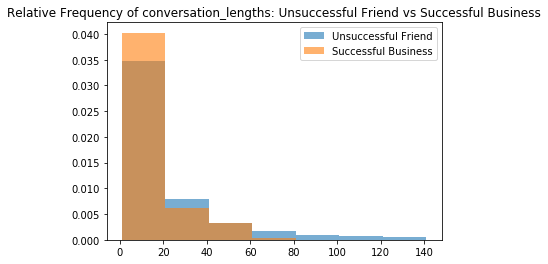

No handles with labels found to put in legend.


Successful Romance Unsuccessful Romance Metric Disparities
Successful Romance friend_response_times mean: 1.6114546484375
Unsuccessful Romance friend_response_times mean: 0.4607878447872838
Difference: 1.1506668036502163 Effect Size: 0.5342538580476569
Bin: 0.0 Successful Romance Minus Unsuccessful Romance : -0.1665844480928691
Bin: 0.5 Successful Romance Minus Unsuccessful Romance : -0.06702420603951137
Bin: 2.0 Successful Romance Minus Unsuccessful Romance : 0.02472468506533034
Bin: 3.0 Successful Romance Minus Unsuccessful Romance : 0.016080123348972457
Bin: 5.0 Successful Romance Minus Unsuccessful Romance : 0.016056196688409432


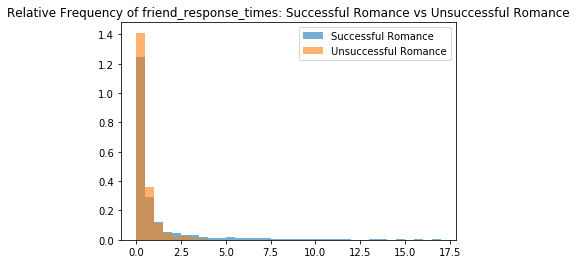

In [9]:
import math
def find_outliers(y,thresh=3.5):
    # warning: this function does not check for NAs
    # nor does it address issues when 
    # more than 50% of your data have identical values
    m = np.median(y)
    abs_dev = np.abs(y - m)
    left_mad = np.median(abs_dev[y <= m])
    right_mad = np.median(abs_dev[y >= m])
    y_mad = left_mad * np.ones(len(y))
    y_mad[y > m] = right_mad
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[y == m] = 0
    return modified_z_score > thresh

def extract_non_outliers(values , mask):
    toreturn = []
    for counter, value in enumerate(values):
        if mask[counter] == False:
            toreturn.append(value)
    return toreturn

def remove_outliers(list_to_remove):
    return extract_non_outliers(list_to_remove, find_outliers(list_to_remove))

#remove outliers for metrics that require it
for tag in master_dict:
    master_dict[tag]['friend_wordcounts'] = remove_outliers(master_dict[tag]['friend_wordcounts'])
    master_dict[tag]['my_wordcounts'] = remove_outliers(master_dict[tag]['my_wordcounts'])
    master_dict[tag]['friend_response_times'] = remove_outliers(master_dict[tag]['friend_response_times'])
    master_dict[tag]['conversation_lengths'] = remove_outliers(master_dict[tag]['conversation_lengths'])

def effect_size(list1, list2):
    return (np.mean(list1) - np.mean(list2)) / math.sqrt((np.std(list1)**2 + np.std(list2)**2)/2)

def get_enriched_metrics(tag1, tag2):
    metrics = master_dict[tag1].keys()
    enriched_metrics = []
    for metric in metrics:
        cohens = effect_size(master_dict[tag1][metric], master_dict[tag2][metric])
        if cohens > 0.5:
            enriched_metrics.append((metric, cohens))
    return enriched_metrics

bin_sizes_by_metric = {'friend_wordcounts': 5, 'my_wordcounts': 5, 'my_response_times': 0.5
                      'my_messages_per_message_group': 1, 'friend_messages_per_message_group': 1,
                      'my_sentiments': 0.1, 'friend_sentiments': 0.1,
                      'conversation_lengths': 20,
                     'friend_response_times': 0.5}

def analyze_enriched_metric(metric, tag1, tag2):
    
    metric_name, cohens = metric[0], metric[1]
    list1 = master_dict[tag1][metric_name]
    list2 = master_dict[tag2][metric_name]
    mean_difference = np.mean(list1) - np.mean(list2)
    print(tag1, metric_name, "mean:", np.mean(list1))
    print(tag2, metric_name, "mean:", np.mean(list2))
    print('Difference:', mean_difference, "Effect Size:", cohens)
    bin_size = bin_sizes_by_metric[metric_name]
    list1.extend(list2)
    max_value = max(list1)
    min_value = min(list1)
    plt.legend(loc='upper right')
    
    (n1, bins, patches) = plt.hist(list1, density = True, alpha = 0.6, bins=np.arange(min_value, max_value + bin_size, bin_size), label = tag1)
    (n2, bins, patches) = plt.hist(list2, density = True, alpha = 0.6, bins=np.arange(min_value, max_value + bin_size, bin_size), label = tag2)
    frequency_difference = [a-b for a,b in zip(n1, n2)]
    frequency_difference = [(counter, value) for counter, value in enumerate(frequency_difference)]
    frequency_difference = sorted(frequency_difference, key = lambda x: abs(x[1]), reverse = True)[0:5]
    for counter, value in frequency_difference:
        print("Bin:", counter*bin_size, tag1, "Minus", tag2, ":", value)
    plt.legend(loc='upper right')
    plt.title("Relative Frequency of " + metric_name + ": " + tag1 + " vs " + tag2)
    plt.show()
    
    
tags = [tag for tag in master_dict.keys()]
counter = 0 
while counter < len(tags):
    for rest in tags[counter+1:len(tags)]:
        enriched_metrics = get_enriched_metrics(tags[counter], rest)
        if len(enriched_metrics) > 0:
            print(tags[counter], rest, "Metric Disparities")
            for metric in enriched_metrics:
                if metric[0] != 'convo_init_info':
                    analyze_enriched_metric(metric, tags[counter], rest)
    counter += 1
    


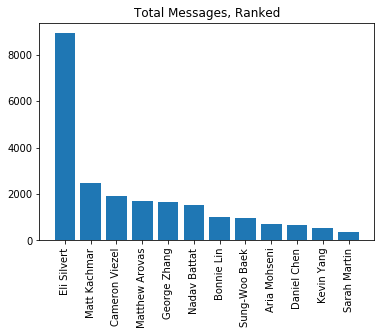

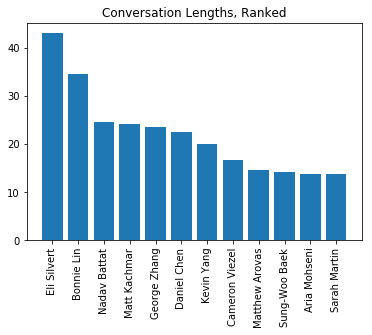

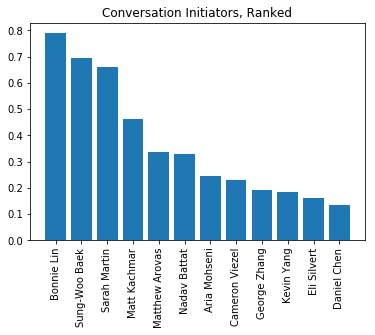

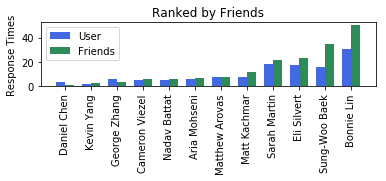

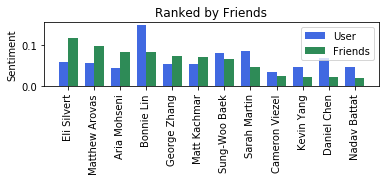

In [10]:
#Rank friends by various metrics. For top 3 friends of each metric, show their histograms pertaining to that metric

#total message ranking

friend_and_message_count = [(friend, friend_data[friend]['total_messages']) for friend in friend_data]
friend_message_counts = sorted(friend_and_message_count, key = lambda x: x[1], reverse=True)
plt.bar([friend[0] for friend in friend_message_counts],[friend[1] for friend in friend_message_counts])
plt.xticks(rotation=90)
plt.title('Total Messages, Ranked')
plt.show()

#convo length ranking
friend_convo_lengths = [(friend, np.mean(friend_data[friend]['conversation_lengths'])) for friend in friend_data]
friend_convo_lengths = sorted(friend_convo_lengths, key = lambda x: x[1], reverse=True)
plt.bar([friend[0] for friend in friend_convo_lengths],[friend[1] for friend in friend_convo_lengths])
plt.xticks(rotation=90)
plt.title('Conversation Lengths, Ranked')
plt.show()

#percentage of convos initiated by friend, ranked
convo_initiators = [(friend, np.mean(friend_data['participantInfo']['friend']['pctConvosInitiated'])) for friend in friend_data]
convo_initiators = sorted(convo_initiators, key = lambda x: x[1], reverse = True)
plt.bar([friend[0] for friend in convo_initiators], [friend[1] for friend in convo_initiators])
plt.xticks(rotation = 90)
plt.title("Conversation Initiators, Ranked")
plt.show()

def plot_side_by_side(friend_list, friend_info, user_info, metric):

    N = len(friend_data)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars
    fig = plt.figure()
    ax = fig.add_subplot(311)

    rects1 = ax.bar(ind, user_info, width, color='royalblue')
    rects2 = ax.bar(ind+width, friend_info, width, color='seagreen')

    # add some labels
    ax.set_ylabel(metric)
    ax.set_title('Ranked by Friends')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(friend_list, rotation=90)
    ax.legend((rects1[0], rects2[0]), ('User', 'Friends'))

#sorted by friends
response_times_sorted = [(friend, np.mean(friend_data[friend]['participantInfo'][friend]['response_times']), np.mean(friend_data[friend]['participantInfo'][user_name]['response_times'])) for friend in friend_data]
response_times_sorted = sorted(response_times_sorted, key = lambda x:x[1])
plot_side_by_side([friend[0] for friend in response_times_sorted],  [friend[1] for friend in response_times_sorted], [friend[2] for friend in response_times_sorted], "Response Times") 


sentiment_sorted = [(friend, np.mean(friend_data[friend]['participantInfo'][friend]['message_sentiments']), np.mean(friend_data[friend]['participant_info'][user_name]['message_sentiments'])) for friend in friend_data]
sentiment_sorted = sorted(sentiment_sorted, key = lambda x:x[1], reverse = True)
plot_side_by_side([friend[0] for friend in sentiment_sorted],  [friend[1] for friend in sentiment_sorted], [friend[2] for friend in sentiment_sorted], "Sentiment") 



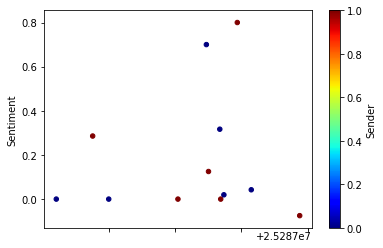

BEST 10 MESSAGE INTERVAL: 1 TO 11
AVERAGE SENTIMENT IN BEST INTERVAL (PER MESSAGE GROUP): 0.22890128968253967
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.2857142857142857
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.0
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
Sung-Woo Baek NO MESSAGE
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.7
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.125
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.3166666666666667
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTE

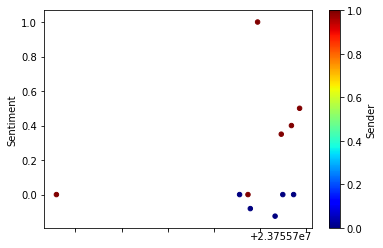

BEST 10 MESSAGE INTERVAL: 0 TO 10
AVERAGE SENTIMENT IN BEST INTERVAL (PER MESSAGE GROUP): 0.15437499999999998
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.0
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.0
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.0
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE C

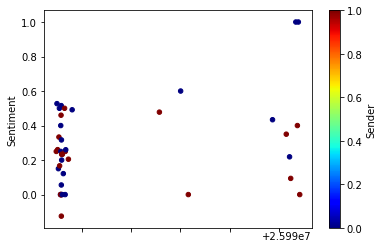

BEST 10 MESSAGE INTERVAL: 30 TO 40
AVERAGE SENTIMENT IN BEST INTERVAL (PER MESSAGE GROUP): 0.4574027777777777
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.4777777777777778
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.6
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.0
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY P

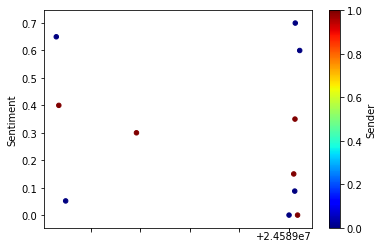

BEST 10 MESSAGE INTERVAL: 0 TO 10
AVERAGE SENTIMENT IN BEST INTERVAL (PER MESSAGE GROUP): 0.2689166666666667
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.65
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.4
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.051666666666666666
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY

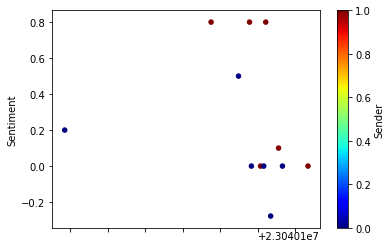

BEST 10 MESSAGE INTERVAL: 0 TO 10
AVERAGE SENTIMENT IN BEST INTERVAL (PER MESSAGE GROUP): 0.2922222222222222
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.2
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.8
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.5
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.8
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.0
THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS
0.0
THIS NORMALLY PRINT

In [11]:
'''OVERVIEW: For top 5 positive friends, return highest sentiment convo (above a certain length) 
+ what the sentiment is. 
Within each top convo, plot progression of sentiment over time to identify peaks in conversation. 
Determine most positive interval (length of interval is subject to change, for now it's 10 message groups)
Return said interval'''
import datetime
import pylab as pl
from matplotlib import collections  as mc

# dictionary of friends: total sentiment between the two of you
friend_dict_sentiment = {friend: (friend_data[friend]['participant_info'][friend]['avg_sentiment_per_message'] + friend_data[friend]['participant_info'][uers_name]['avg_sentiment_per_message']) for friend in friend_data.keys()}
#sorted by sentiment
friend_dict_sentiment = sorted(friend_dict_sentiment, key = lambda item: item[1], reverse = True)
#select top 5 highest sentiment friends
top_5_friends = friend_dict_sentiment[0:5]


#for each of top 5 friends
for friend in top_5_friends: #CHANGE TO top_5_friends
    #get list of message group sentiments for each convo 
    convo_sentiments_not_averaged = friend_data[friend]['convo_sentiments']
    
    #get average sentiment per message group of each convo
    convo_sentiments_averaged = []
    for number, convo in enumerate(convo_sentiments_not_averaged):
        if len(friend_convos[friend][number]) > 10:
            convo_sentiments_averaged.append((number, np.mean(convo), len(friend_convos[friend][number])))
            
    # find top conversation's content, average sentiment, and length
    top_conversation = sorted(convo_sentiments_averaged, reverse = True, key = lambda tup: tup[1])[0]
    top_conversation_number, top_conversation_average_sentiment, top_conversation_length = top_conversation[0], top_conversation[1], top_conversation[2]
    top_conversation_content = friend_convos[friend][top_conversation_number]
    
    #progression of top conversation's sentiment over course of converation
    top_convo_sentiment_progression = convo_sentiments_not_averaged[top_conversation_number]
    
    x = [msg_group[0]['timestamp_ms']/1000/60 for msg_group in top_conversation_content]
    y = [np.mean(msg_group) for msg_group in top_convo_sentiment_progression]
    sender_indices = [1 if top_conversation_content[counter][0]['sender_name'] != user_name else 0 for counter, value in enumerate(top_conversation_content)]
    
    df = pd.DataFrame(list(zip(x, y, sender_indices)), 
               columns =['Message Group', 'Sentiment', 'Sender']) 
    df.plot.scatter(x='Message Group', y='Sentiment', c='Sender', colormap='jet')
    plt.show()
    #find best 10-message snippet of the conversation 
    
    snippet_length = 10
    snippet_start = 0
    best_snippet = 0
    best_snippet_index = 0 

    while snippet_start < len(y) - snippet_length:
        snippet_sum = sum(y[snippet_start:(snippet_start + snippet_length)])
        if snippet_sum > best_snippet:
            best_snippet = snippet_sum
            best_snippet_index = snippet_start
        snippet_start += 1
    print("BEST 10 MESSAGE INTERVAL:", best_snippet_index, "TO", best_snippet_index + snippet_length)
    print("AVERAGE SENTIMENT IN BEST INTERVAL (PER MESSAGE GROUP):", best_snippet/snippet_length)
    
    #return best snippet content and the corresponding message group sentiments
    for counter1, msg_group in enumerate(top_conversation_content[best_snippet_index:(best_snippet_index + snippet_length)]):
        for counter, msg in enumerate(msg_group):
            if 'content' in msg.keys():
                print("THIS NORMALLY PRINTS OUT THE CONTENTS OF A CONVERSATION, BUT I COMMENTED OUT THE CODE FOR PRIVACY REASONS")
                #print(msg['sender_name'], msg['content'])
                if counter == len(msg_group) - 1:
                    
                    print(top_convo_sentiment_progression[best_snippet_index + counter1]) 
            else:
                print(msg['sender_name'] + " NO MESSAGE")
    #return 
    

In [12]:

monthly_sentiment = {}
monthly_total = {}
monthly_average = {}

years = [year for year in range(2013, 2020)]
for year in years:
    monthly_sentiment[year] = Counter()
    monthly_total[year] = Counter()
    monthly_average[year] = [0]*12
def parse_message(message):
    final_message = ''
    for msg in message:
        final_message += msg
    return final_message
for message in msg_user:
    year = message[0].year
    month = message[0].month
    if year not in [2010,2011,2012]:
        final_message = ''
        for msg in message[1]:
            final_message += msg
        monthly_sentiment[year][month] += TextBlob(final_message).polarity
        monthly_total[year][month] += 1
for year in years:
    if year != 2019:
        for month in range(0,12):
            if monthly_total[year][month] != 0:
                monthly_average[year][month] = monthly_sentiment[year][month] / monthly_total[year][month]
    else:
        for month in range(0,7):
            if monthly_total[year][month] != 0:
                monthly_average[year][month] = monthly_sentiment[year][month] / monthly_total[year][month]
from operator import itemgetter
sent_avg = []
for year in monthly_average:
    for value in monthly_average[year]:
        sent_avg.append(value)
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(x=pd.date_range(start='1/1/2013', periods=79, freq='1M'), y=sent_avg)])
fig.update_layout(
    title=go.layout.Title(
        text= "Sentiment over time"))
fig.show()


WORDS IN COMMON WITH Aria Mohseni


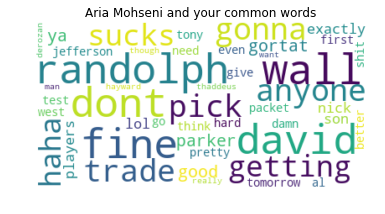


WORD/PHRASES USED FREQUENTLY BY ONE PERSON

Ooga Nam COMMON PHRASES
aria Usage
Ooga Nam 7 times Aria Mohseni: 0 times
cuz Usage
Ooga Nam 4 times Aria Mohseni: 0 times
giving Usage
Ooga Nam 6 times Aria Mohseni: 0 times
say Usage
Ooga Nam 4 times Aria Mohseni: 0 times
thad Usage
Ooga Nam 4 times Aria Mohseni: 0 times
spencer Usage
Ooga Nam 4 times Aria Mohseni: 0 times
much Usage
Ooga Nam 4 times Aria Mohseni: 0 times
deng Usage
Ooga Nam 4 times Aria Mohseni: 0 times
done Usage
Ooga Nam 5 times Aria Mohseni: 0 times
talk Usage
Ooga Nam 4 times Aria Mohseni: 0 times
word Usage
Ooga Nam 5 times Aria Mohseni: 0 times
fuck Usage
Ooga Nam 5 times Aria Mohseni: 0 times
afflalo Usage
Ooga Nam 5 times Aria Mohseni: 0 times
listen Usage
Ooga Nam 5 times Aria Mohseni: 0 times
easy Usage
Ooga Nam 4 times Aria Mohseni: 1 times
make Usage
Ooga Nam 10 times Aria Mohseni: 1 times
time Usage
Ooga Nam 5 times Aria Mohseni: 1 times
know Usage
Ooga Nam 12 times Aria Mohseni: 2 times
hawes Usage
Ooga Nam 

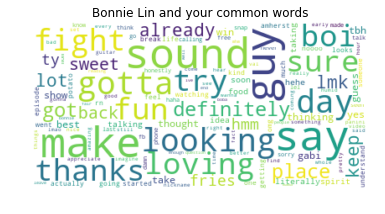


WORD/PHRASES USED FREQUENTLY BY ONE PERSON

Ooga Nam COMMON PHRASES
letas Usage
Ooga Nam 5 times Bonnie Lin: 0 times
cuz Usage
Ooga Nam 8 times Bonnie Lin: 0 times
iall Usage
Ooga Nam 8 times Bonnie Lin: 0 times
xd Usage
Ooga Nam 6 times Bonnie Lin: 0 times
need Usage
Ooga Nam 5 times Bonnie Lin: 0 times
iam Usage
Ooga Nam 16 times Bonnie Lin: 0 times
bon Usage
Ooga Nam 5 times Bonnie Lin: 0 times
shit Usage
Ooga Nam 7 times Bonnie Lin: 1 times
lit Usage
Ooga Nam 5 times Bonnie Lin: 1 times
14 Usage
Ooga Nam 6 times Bonnie Lin: 1 times
holy Usage
Ooga Nam 6 times Bonnie Lin: 1 times
lol Usage
Ooga Nam 52 times Bonnie Lin: 16 times
even Usage
Ooga Nam 8 times Bonnie Lin: 1 times
week Usage
Ooga Nam 5 times Bonnie Lin: 1 times
mean Usage
Ooga Nam 5 times Bonnie Lin: 1 times
Bonnie Lin COMMON PHRASES
oooh Usage
Ooga Nam 0 times Bonnie Lin: 5 times
room Usage
Ooga Nam 0 times Bonnie Lin: 6 times
aai  Usage
Ooga Nam 0 times Bonnie Lin: 5 times
watch Usage
Ooga Nam 0 times Bonnie Lin: 6 tim

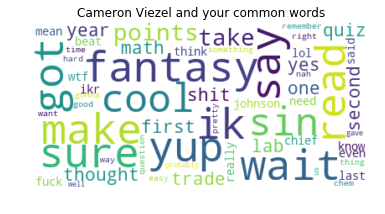


WORD/PHRASES USED FREQUENTLY BY ONE PERSON

Ooga Nam COMMON PHRASES
put Usage
Ooga Nam 10 times Cameron Viezel: 0 times
anything Usage
Ooga Nam 10 times Cameron Viezel: 0 times
ight Usage
Ooga Nam 15 times Cameron Viezel: 0 times
ya Usage
Ooga Nam 17 times Cameron Viezel: 0 times
cuz Usage
Ooga Nam 17 times Cameron Viezel: 4 times
could Usage
Ooga Nam 13 times Cameron Viezel: 3 times
two Usage
Ooga Nam 12 times Cameron Viezel: 1 times
page Usage
Ooga Nam 10 times Cameron Viezel: 1 times
cam Usage
Ooga Nam 18 times Cameron Viezel: 1 times
haha Usage
Ooga Nam 10 times Cameron Viezel: 1 times
look Usage
Ooga Nam 13 times Cameron Viezel: 3 times
test Usage
Ooga Nam 18 times Cameron Viezel: 4 times
see Usage
Ooga Nam 10 times Cameron Viezel: 3 times
questions Usage
Ooga Nam 11 times Cameron Viezel: 3 times
Cameron Viezel COMMON PHRASES
um Usage
Ooga Nam 1 times Cameron Viezel: 11 times
thats Usage
Ooga Nam 1 times Cameron Viezel: 14 times
nice Usage
Ooga Nam 1 times Cameron Viezel: 12 time

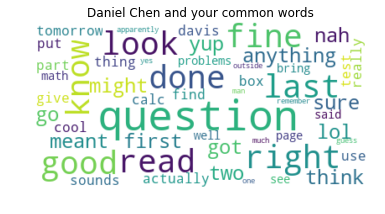


WORD/PHRASES USED FREQUENTLY BY ONE PERSON

Ooga Nam COMMON PHRASES
message Usage
Ooga Nam 4 times Daniel Chen: 0 times
charge Usage
Ooga Nam 4 times Daniel Chen: 0 times
yr Usage
Ooga Nam 4 times Daniel Chen: 0 times
four Usage
Ooga Nam 4 times Daniel Chen: 0 times
ya Usage
Ooga Nam 11 times Daniel Chen: 0 times
history Usage
Ooga Nam 6 times Daniel Chen: 0 times
five Usage
Ooga Nam 4 times Daniel Chen: 0 times
hahaha Usage
Ooga Nam 4 times Daniel Chen: 0 times
dan Usage
Ooga Nam 10 times Daniel Chen: 0 times
debate Usage
Ooga Nam 4 times Daniel Chen: 1 times
gonna Usage
Ooga Nam 8 times Daniel Chen: 2 times
could Usage
Ooga Nam 6 times Daniel Chen: 1 times
haha Usage
Ooga Nam 12 times Daniel Chen: 1 times
thanks Usage
Ooga Nam 19 times Daniel Chen: 4 times
hard Usage
Ooga Nam 4 times Daniel Chen: 1 times
class Usage
Ooga Nam 4 times Daniel Chen: 1 times
chem Usage
Ooga Nam 8 times Daniel Chen: 1 times
quiz Usage
Ooga Nam 8 times Daniel Chen: 2 times
Daniel Chen COMMON PHRASES
wrong 

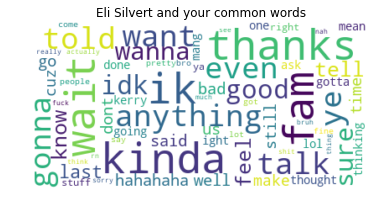


WORD/PHRASES USED FREQUENTLY BY ONE PERSON

Ooga Nam COMMON PHRASES
Eli Silvert COMMON PHRASES
yee Usage
Ooga Nam 4 times Eli Silvert: 62 times
sounds Usage
Ooga Nam 12 times Eli Silvert: 52 times
thats Usage
Ooga Nam 13 times Eli Silvert: 100 times
nice Usage
Ooga Nam 8 times Eli Silvert: 65 times
hahah Usage
Ooga Nam 2 times Eli Silvert: 93 times
hahaha Usage
Ooga Nam 40 times Eli Silvert: 140 times
haha Usage
Ooga Nam 97 times Eli Silvert: 311 times

WORDS IN COMMON WITH George Zhang


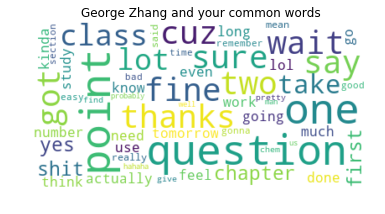


WORD/PHRASES USED FREQUENTLY BY ONE PERSON

Ooga Nam COMMON PHRASES
george Usage
Ooga Nam 52 times George Zhang: 0 times
ya Usage
Ooga Nam 16 times George Zhang: 0 times
grade Usage
Ooga Nam 9 times George Zhang: 2 times
day Usage
Ooga Nam 9 times George Zhang: 2 times
read Usage
Ooga Nam 9 times George Zhang: 2 times
thought Usage
Ooga Nam 11 times George Zhang: 2 times
notes Usage
Ooga Nam 17 times George Zhang: 5 times
haha Usage
Ooga Nam 34 times George Zhang: 1 times
essay Usage
Ooga Nam 16 times George Zhang: 5 times
test Usage
Ooga Nam 13 times George Zhang: 4 times
part Usage
Ooga Nam 16 times George Zhang: 5 times
see Usage
Ooga Nam 10 times George Zhang: 2 times
though Usage
Ooga Nam 12 times George Zhang: 1 times
right Usage
Ooga Nam 12 times George Zhang: 3 times
history Usage
Ooga Nam 19 times George Zhang: 2 times
hastings Usage
Ooga Nam 11 times George Zhang: 3 times
George Zhang COMMON PHRASES
court Usage
Ooga Nam 0 times George Zhang: 19 times
supreme Usage
Ooga Nam 0

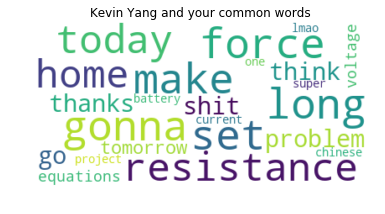


WORD/PHRASES USED FREQUENTLY BY ONE PERSON

Ooga Nam COMMON PHRASES
slides Usage
Ooga Nam 5 times Kevin Yang: 0 times
ight Usage
Ooga Nam 5 times Kevin Yang: 0 times
dope Usage
Ooga Nam 10 times Kevin Yang: 0 times
wat Usage
Ooga Nam 6 times Kevin Yang: 0 times
homie Usage
Ooga Nam 3 times Kevin Yang: 0 times
hw Usage
Ooga Nam 12 times Kevin Yang: 0 times
rn Usage
Ooga Nam 3 times Kevin Yang: 0 times
times Usage
Ooga Nam 5 times Kevin Yang: 0 times
da Usage
Ooga Nam 3 times Kevin Yang: 0 times
haha Usage
Ooga Nam 4 times Kevin Yang: 0 times
know Usage
Ooga Nam 3 times Kevin Yang: 0 times
fam Usage
Ooga Nam 3 times Kevin Yang: 0 times
tru Usage
Ooga Nam 3 times Kevin Yang: 0 times
phys Usage
Ooga Nam 17 times Kevin Yang: 0 times
fuck Usage
Ooga Nam 11 times Kevin Yang: 0 times
problems Usage
Ooga Nam 4 times Kevin Yang: 0 times
would Usage
Ooga Nam 3 times Kevin Yang: 0 times
pic Usage
Ooga Nam 3 times Kevin Yang: 0 times
ya Usage
Ooga Nam 7 times Kevin Yang: 0 times
story Usage
Ooga N

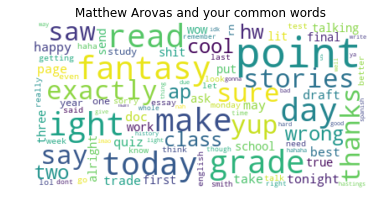


WORD/PHRASES USED FREQUENTLY BY ONE PERSON

Ooga Nam COMMON PHRASES
matt Usage
Ooga Nam 19 times Matthew Arovas: 0 times
ik Usage
Ooga Nam 11 times Matthew Arovas: 2 times
cuz Usage
Ooga Nam 14 times Matthew Arovas: 1 times
Matthew Arovas COMMON PHRASES
always Usage
Ooga Nam 0 times Matthew Arovas: 10 times
gotta Usage
Ooga Nam 0 times Matthew Arovas: 9 times
guess Usage
Ooga Nam 0 times Matthew Arovas: 15 times
someone Usage
Ooga Nam 0 times Matthew Arovas: 10 times
fine Usage
Ooga Nam 5 times Matthew Arovas: 18 times
parsons Usage
Ooga Nam 3 times Matthew Arovas: 10 times
players Usage
Ooga Nam 3 times Matthew Arovas: 11 times
team Usage
Ooga Nam 4 times Matthew Arovas: 16 times
got Usage
Ooga Nam 16 times Matthew Arovas: 66 times
lot Usage
Ooga Nam 2 times Matthew Arovas: 12 times
back Usage
Ooga Nam 3 times Matthew Arovas: 15 times
little Usage
Ooga Nam 1 times Matthew Arovas: 10 times
get Usage
Ooga Nam 10 times Matthew Arovas: 36 times
game Usage
Ooga Nam 2 times Matthew Arovas:

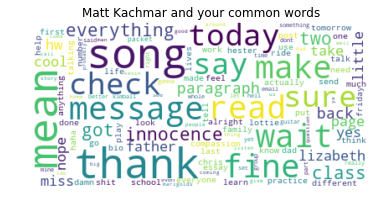


WORD/PHRASES USED FREQUENTLY BY ONE PERSON

Ooga Nam COMMON PHRASES
yup Usage
Ooga Nam 21 times Matt Kachmar: 2 times
hope Usage
Ooga Nam 15 times Matt Kachmar: 4 times
matt Usage
Ooga Nam 18 times Matt Kachmar: 5 times
lol Usage
Ooga Nam 24 times Matt Kachmar: 6 times
Matt Kachmar COMMON PHRASES
min Usage
Ooga Nam 0 times Matt Kachmar: 14 times
ooga Usage
Ooga Nam 1 times Matt Kachmar: 18 times
bring Usage
Ooga Nam 1 times Matt Kachmar: 13 times
going Usage
Ooga Nam 3 times Matt Kachmar: 17 times
long Usage
Ooga Nam 4 times Matt Kachmar: 13 times
pearl Usage
Ooga Nam 1 times Matt Kachmar: 21 times
want Usage
Ooga Nam 2 times Matt Kachmar: 32 times
pretty Usage
Ooga Nam 3 times Matt Kachmar: 13 times

WORDS IN COMMON WITH Nadav Battat


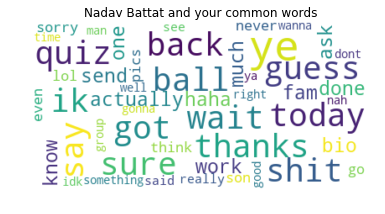


WORD/PHRASES USED FREQUENTLY BY ONE PERSON

Ooga Nam COMMON PHRASES
cuz Usage
Ooga Nam 9 times Nadav Battat: 0 times
doov Usage
Ooga Nam 20 times Nadav Battat: 0 times
ight Usage
Ooga Nam 21 times Nadav Battat: 2 times
bro Usage
Ooga Nam 9 times Nadav Battat: 2 times
icarus Usage
Ooga Nam 8 times Nadav Battat: 1 times
let Usage
Ooga Nam 10 times Nadav Battat: 2 times
Nadav Battat COMMON PHRASES
aight Usage
Ooga Nam 0 times Nadav Battat: 12 times
ah Usage
Ooga Nam 1 times Nadav Battat: 13 times
wut Usage
Ooga Nam 2 times Nadav Battat: 8 times
tomorrow Usage
Ooga Nam 3 times Nadav Battat: 13 times
thats Usage
Ooga Nam 1 times Nadav Battat: 8 times
kinda Usage
Ooga Nam 2 times Nadav Battat: 8 times
alright Usage
Ooga Nam 3 times Nadav Battat: 13 times
ill Usage
Ooga Nam 3 times Nadav Battat: 12 times
mean Usage
Ooga Nam 2 times Nadav Battat: 14 times
want Usage
Ooga Nam 1 times Nadav Battat: 12 times
cant Usage
Ooga Nam 1 times Nadav Battat: 10 times

WORDS IN COMMON WITH Sarah Martin


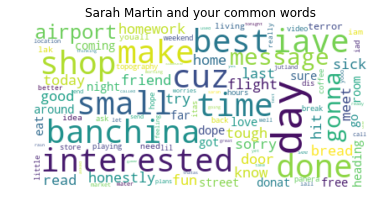


WORD/PHRASES USED FREQUENTLY BY ONE PERSON

Ooga Nam COMMON PHRASES
tryna Usage
Ooga Nam 2 times Sarah Martin: 0 times
yup Usage
Ooga Nam 2 times Sarah Martin: 0 times
thanks Usage
Ooga Nam 4 times Sarah Martin: 0 times
downstairs Usage
Ooga Nam 2 times Sarah Martin: 0 times
bus Usage
Ooga Nam 2 times Sarah Martin: 0 times
btw Usage
Ooga Nam 3 times Sarah Martin: 0 times
lmk Usage
Ooga Nam 3 times Sarah Martin: 0 times
sweet Usage
Ooga Nam 3 times Sarah Martin: 0 times
havenat Usage
Ooga Nam 2 times Sarah Martin: 0 times
cope Usage
Ooga Nam 2 times Sarah Martin: 0 times
visiting Usage
Ooga Nam 3 times Sarah Martin: 0 times
msg Usage
Ooga Nam 3 times Sarah Martin: 0 times
somewhere Usage
Ooga Nam 2 times Sarah Martin: 0 times
emmerys Usage
Ooga Nam 2 times Sarah Martin: 0 times
weare Usage
Ooga Nam 6 times Sarah Martin: 0 times
shit Usage
Ooga Nam 3 times Sarah Martin: 0 times
actually Usage
Ooga Nam 4 times Sarah Martin: 0 times
sounds Usage
Ooga Nam 6 times Sarah Martin: 0 times
bota

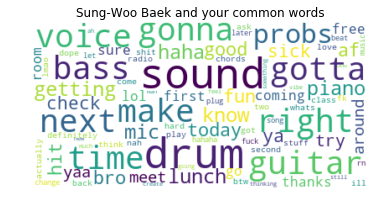


WORD/PHRASES USED FREQUENTLY BY ONE PERSON

Ooga Nam COMMON PHRASES
great Usage
Ooga Nam 5 times Sung-Woo Baek: 0 times
lit Usage
Ooga Nam 11 times Sung-Woo Baek: 0 times
bit Usage
Ooga Nam 5 times Sung-Woo Baek: 0 times
iall Usage
Ooga Nam 8 times Sung-Woo Baek: 0 times
yuh Usage
Ooga Nam 5 times Sung-Woo Baek: 0 times
word Usage
Ooga Nam 19 times Sung-Woo Baek: 0 times
tru Usage
Ooga Nam 6 times Sung-Woo Baek: 0 times
ite Usage
Ooga Nam 7 times Sung-Woo Baek: 0 times
tm Usage
Ooga Nam 5 times Sung-Woo Baek: 0 times
iam Usage
Ooga Nam 14 times Sung-Woo Baek: 0 times
werd Usage
Ooga Nam 5 times Sung-Woo Baek: 0 times
itas Usage
Ooga Nam 10 times Sung-Woo Baek: 0 times
lil Usage
Ooga Nam 5 times Sung-Woo Baek: 1 times
cool Usage
Ooga Nam 10 times Sung-Woo Baek: 2 times
ye Usage
Ooga Nam 7 times Sung-Woo Baek: 1 times
yet Usage
Ooga Nam 7 times Sung-Woo Baek: 1 times
Sung-Woo Baek COMMON PHRASES
keep Usage
Ooga Nam 0 times Sung-Woo Baek: 5 times
sweet Usage
Ooga Nam 0 times Sung-Woo Bae

In [13]:
'''OVERVIEW: FOR TOP 10 MOST MESSAGED FRIENDS, FIND WORDS AND PHRASES COMMON TO YOU BOTH'''
#method that returns list of n-grams given a tokenized word list, and n
def find_ngrams(input_list, n):
      return zip(*[input_list[i:] for i in range(n)])

def print_words(p1, p2, keyyy):
    print(p1.upper() + "'S " +  "FREQUENT WORD")
    print(p1 + " used " + wholekey + " " + str(ngram_dict[p1][keyyy]) + " times")
    if keyyy in ngram_dict[p2].keys():
        print(p2 + " used " + wholekey + " " + str(ngram_dict[p2][keyyy]) + " times")
        print()
    else:
        print(p2 + " used " + wholekey + " " + '0' + " times")
        print()    
#for each friend 
for friend in friend_convos:
    #get content of conversation
    conversation = friend_convos[friend]
    #explore one to three word long phrases
    
    ngram_dict = {}
    ngram_dict[user_name] = Counter()
    ngram_dict[friend] = Counter()
   
    for msg_group in conversation:
        #for each message
        for msg in msg_group:
            #if message has text content
            if 'content' in msg[0].keys():
                #get tokenized list of words
                toktok = ToktokTokenizer()
                tokenized = toktok.tokenize(msg[0]['content'])
                tokenized = normalize(tokenized)
                    
                #for each ngram, add 1 to counter for whoever sent the message
                for word in tokenized:
                    if len(word) > 1:
                        ngram_dict[msg[0]['sender_name']][word] += 1
        
    wordintersection = set(ngram_dict[user_name]).intersection(ngram_dict[friend])
    intersectionkeys = [key for key in wordintersection]
    notintersectionkeys = [key for key in set(ngram_dict[user_name] | ngram_dict[friend]) if key not in intersectionkeys]
        
    #looking at words/phrases you and friend have in common
    print()
    print("WORDS IN COMMON WITH " + friend)
        
    whole_text = ""
    for key in intersectionkeys:
        if ngram_dict[user_name][key] > ngram_dict[friend][key] * 3 or ngram_dict[friend][key] > ngram_dict[user_name][key]*3:
            notintersectionkeys.append(key)
        elif ngram_dict[user_name][key] / friend_data[friend]['total_messages'] > .002 and ngram_dict[friend][key] / friend_data[friend]['total_messages'] > .002:
            whole_text += " " + key
        
    if whole_text != "":
        wordcloud = WordCloud(max_font_size=50, max_words=150, background_color="white").generate(whole_text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(friend + " and your common words")
        plt.axis("off")
        plt.show()
    #looking at words/phrases only one of you uses often
    print()
    print("WORD/PHRASES USED FREQUENTLY BY ONE PERSON")
    print()
    my_common_phrases = []
    friend_common_phrases = []
    for key in notintersectionkeys:
        
        #if ngram_dict[user_name][key] > ngram_dict[friend][key] * 3 or ngram_dict[friend][key] > ngram_dict[user_name][key]*3:   
        if key in ngram_dict[user_name].keys() and ngram_dict[user_name][key] > ngram_dict[friend][key] * 3 and ngram_dict[user_name][key] / friend_data[friend]['total_messages']>.005:
            my_common_phrases.append(key)
        elif key in ngram_dict[friend].keys() and ngram_dict[friend][key] > ngram_dict[user_name][key] * 3 and ngram_dict[friend][key] / friend_data[friend]['total_messages']>.005:
            friend_common_phrases.append(key)
    my_common_phrases = Counter(my_common_phrases)
    print(user_name, "COMMON PHRASES")
    for phrase in my_common_phrases:
        print(phrase + " Usage") 
        print(user_name, ngram_dict[user_name][phrase], "times", friend + ":", ngram_dict[friend][phrase], "times")   
        
    print(friend, "COMMON PHRASES")
    for phrase in friend_common_phrases:
        print(phrase + " Usage") 
        print(user_name, ngram_dict[user_name][phrase], "times", friend + ":", ngram_dict[friend][phrase], "times")
        

AVERAGE LENGTH OF MESSAGE (WORDS): 3.9687426996215485
AVERAGE LENGTH OF MESSAGE (CHAR): 20.33892444984348
AVERAGE WORD LENGTH: 5.124777792166511
TOTAL NUMBER OF MESSAGES: 21403


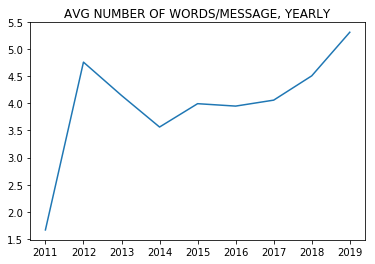

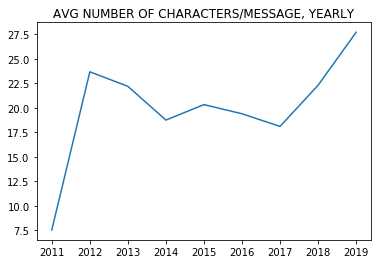

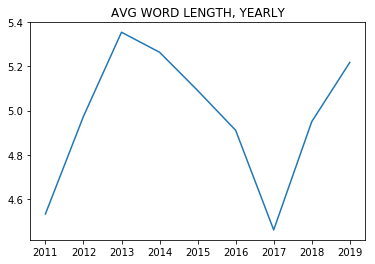

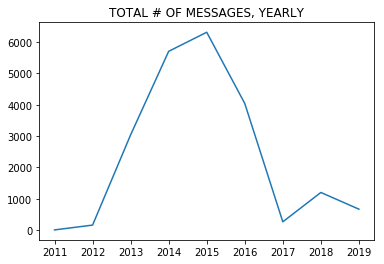

In [14]:
### ANALYSIS OF MESSAGES SENT BY USER ###


#all time averages
avg_num_words = []
avg_num_char = []

#yearly averages
yeardict_words = defaultdict(list)
yeardict_char = defaultdict(list)
yearly_num_messages = Counter()

for message in msg_user:
    year, message = message[0].year, message[1]
    #all time
    
    avg_num_words.append(len(message))
    char = 0
    for msg in message:
        char += len(msg)
    avg_num_char.append(char)
    #yearly
    yeardict_words[year].append(len(message))
    yeardict_char[year].append(char)
    yearly_num_messages[year] += 1

#all time
print("AVERAGE LENGTH OF MESSAGE (WORDS):", np.mean(avg_num_words))
print("AVERAGE LENGTH OF MESSAGE (CHAR):", np.mean(avg_num_char))
print("AVERAGE WORD LENGTH:", np.mean(avg_num_char)/np.mean(avg_num_words))
print("TOTAL NUMBER OF MESSAGES:", len(msg_user))

#the following graphs are yearly
#words per message
years = sorted(j for j in yeardict_words)
years = list(years)
words_per = [np.mean(yeardict_words[year]) for year in years]
plt.plot(years, words_per)
plt.title("AVG NUMBER OF WORDS/MESSAGE, YEARLY")
plt.show()

#characters per message
characters_per = [np.mean(yeardict_char[year]) for year in years]
plt.plot(years, characters_per)
plt.title("AVG NUMBER OF CHARACTERS/MESSAGE, YEARLY")
plt.show()

#average word length
plt.plot(years, [char/words for char, words in zip(characters_per, words_per)])
plt.title("AVG WORD LENGTH, YEARLY")
plt.show()

plt.plot(years, [yearly_num_messages[year] for year in years])
plt.title("TOTAL # OF MESSAGES, YEARLY")
plt.show()

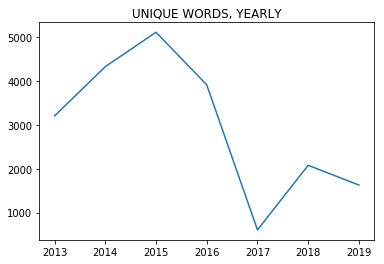

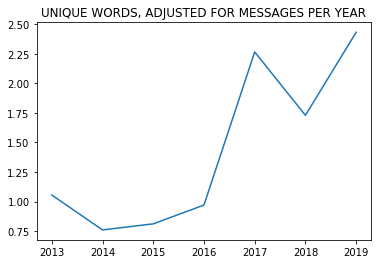

In [15]:
### ANALYSIS OF MESSAGES SENT BY USER ###

bigram_count = {}
wordcount_by_year = {}
for year in range(2013,2020):
    wordcount_by_year[year] = Counter()
    bigram_count[year] = Counter()
stop = ['https','ur', 'u', 'hi', 'yea', 'yeah', 'gon', 'got', 'ta', 'iall', 'na', 'yo', 'hey', 'oh', 'dude', 'tho', 'ok', 'okay', 'wan', 'k']

uniquewords = []
counter = 0
for tup in msg_user:
    if tup[0].year not in [2010,2011,2012]:
        counter += 1
        wrds = tup[1]
        
        for word in wrds:
            if word not in stop:
                wordcount_by_year[tup[0].year][word]+=1
        for bi in bigrams(wrds):
            if list(set(list(bi)) & set(stop)) == []:
                bigram_count[tup[0].year][bi] += 1
            
years1 = years[2:len(years)]
        
unique_wordcount = [len(wordcount_by_year[year]) for year in years1]
plt.plot(years1, unique_wordcount)
plt.title("UNIQUE WORDS, YEARLY")
plt.show()

plt.plot(years1, [a/b for a, b in zip(unique_wordcount,  [yearly_num_messages[year] for year in years1])])
plt.title("UNIQUE WORDS, ADJUSTED FOR MESSAGES PER YEAR")
plt.show()

In [16]:
todelete = []
for year in years1:
    for key in bigram_count[year]:
        if bigram_count[year][key] < 5:
            todelete.append((year,key))
for year, key in todelete:
    del bigram_count[year][key]

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



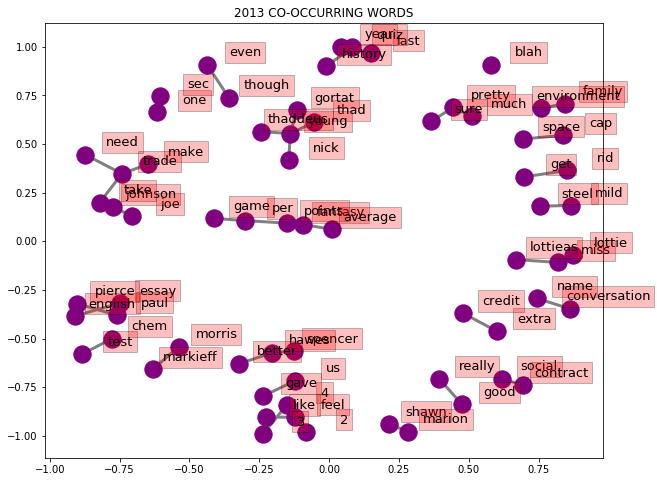

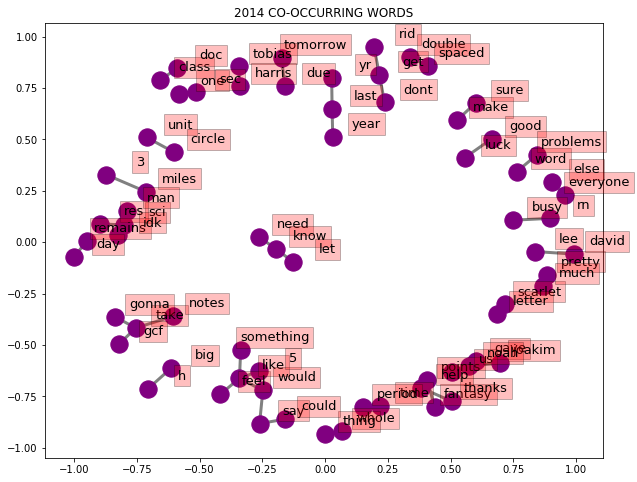

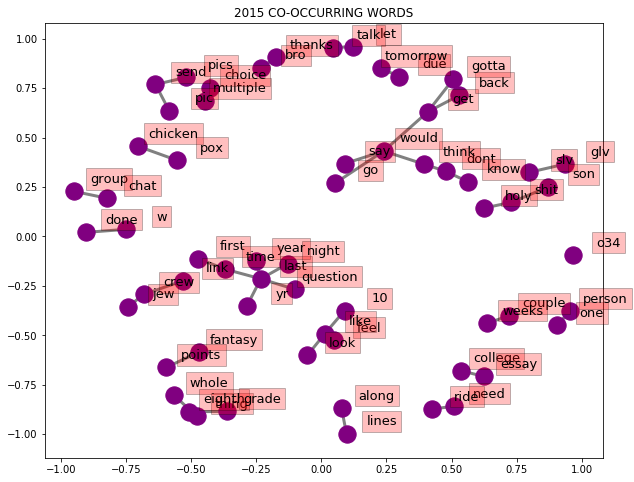

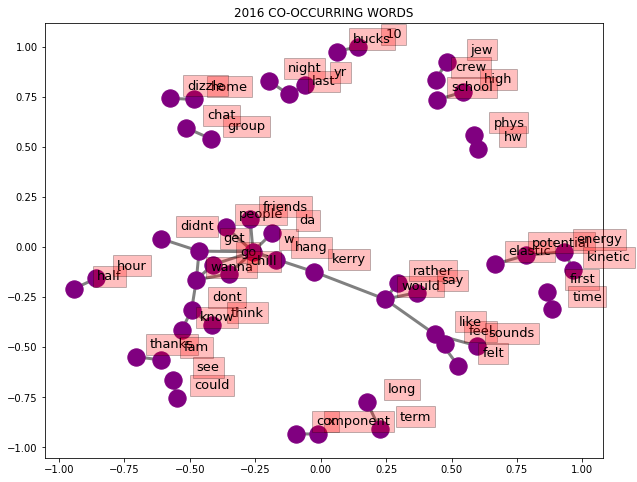

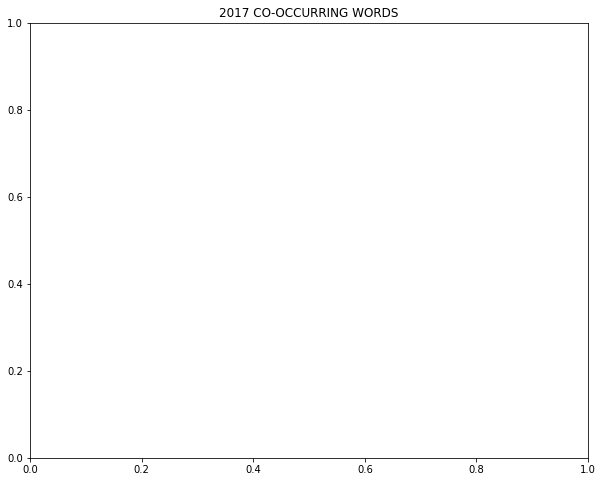

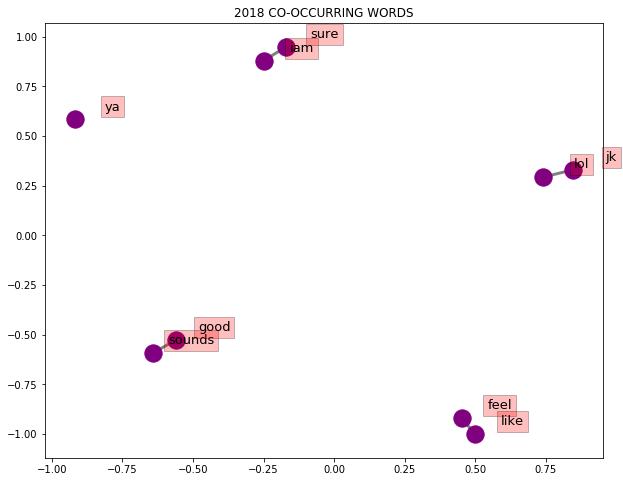

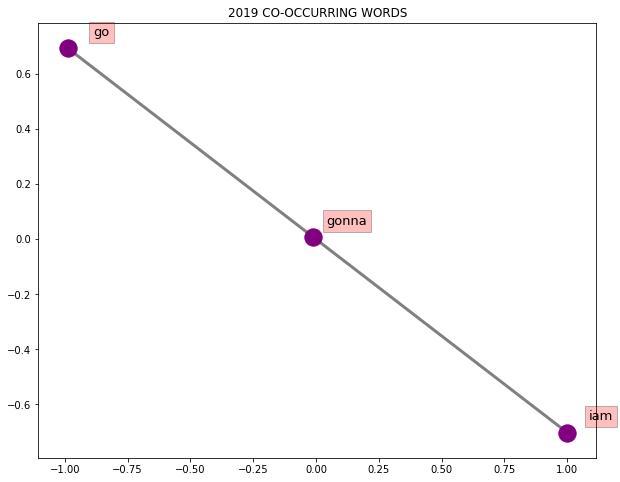

In [17]:
### ANALYSIS OF MESSAGES SENT BY USER ###

for year in years1:
    bigram_df = pd.DataFrame(bigram_count[year].most_common(40),
                             columns=['bigram', 'count'])
# Create dictionary of bigrams and their counts
    d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
    G = nx.Graph()

# Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    fig, ax = plt.subplots(figsize=(10, 8))

    pos = nx.spring_layout(G, k=1)

# Plot networks
    nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.135, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.25),
                horizontalalignment='center', fontsize=13)
    plt.title(str(year) + " CO-OCCURRING WORDS")
    plt.show()